In [1]:
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
import collections as c
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
pwd

'/Users/jeremymiller/GoogleDrive/Data_Science/Galvanize/dsi-capstone/models'

In [4]:
model = pickle.load(open('logistic_regression_completion.p', 'rb')) # load the model

EOFError: Ran out of input

In [5]:
model = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start='False')

In [8]:
def scale_subset(df, columns):
    '''
    Use sklearn StandardScalar to scale only numeric columns.

    Parameters:
    ----------
    input {dataframe, list}: dataframe containing mixed feature variable types, list of names of numeric feature columns
    output: {dataframe}: dataframe with numeric features scaled and categorical features unchanged

    '''
    scalar = StandardScaler()
    numeric = df[columns]
    categorical = df.drop(columns, axis = 1)
    scalar.fit(numeric)
    num_scaled = pd.DataFrame(scalar.transform(numeric))
    num_scaled.rename(columns = dict(zip(num_scaled.columns, numeric_cols)), inplace = True)
    return pd.concat([num_scaled, categorical], axis = 1)


In [9]:
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
y_train = y_train['module_not_completed']
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')
y_test = y_test['module_not_completed']
numeric_cols = ['num_of_prev_attempts', 'studied_credits',
'clicks_per_day', 'pct_days_vle_accessed','max_clicks_one_day',
'first_date_vle_accessed', 'avg_score', 'avg_days_sub_early', 'days_early_first_assessment',
'score_first_assessment']
# fill and scale
X_train.fillna(value = 0, inplace = True)
X_train = scale_subset(X_train, numeric_cols)
X_test.fillna(value = 0, inplace = True)
X_test = scale_subset(X_test, numeric_cols)


/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [10]:
model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start='False')

In [12]:
predictions = model.predict(X_test)

In [13]:
recall = recall_score(y_test, predictions)
recall

0.8367168358417921

In [14]:
roc_auc = roc_auc_score(y_test, predictions)
roc_auc

0.8483148880435712

In [15]:
probas = model.predict_proba(X_test)[:, :1]
tprs, fprs, thresh = roc_curve(y_test, probas)

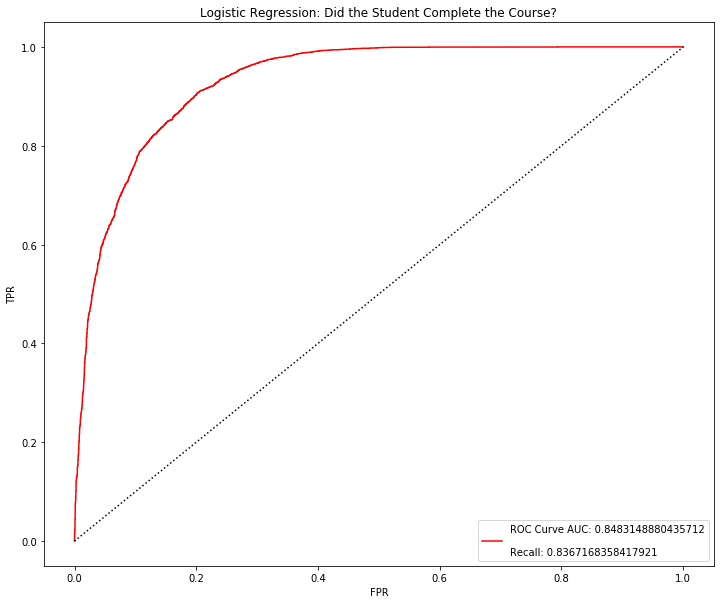

In [16]:
plt.figure(figsize=(12,10))
plt.plot(fprs, tprs, 
    label='ROC Curve AUC: {}\n\nRecall: {}'.format(roc_auc, recall),
    color='red')
plt.plot([0,1],[0,1], 'k:')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Logistic Regression: Did the Student Complete the Course?")
plt.show()

# Which features are most important?

In [17]:
pd.DataFrame(data=model.coef_, columns=X_test.columns).sort_values(by = 0, axis=1)
# list(X_test.columns)

,pct_days_vle_accessed,avg_score,days_early_first_assessment,code_presentation_2014J,code_presentation_2013J,code_presentation_2014B,imd_band_nan,imd_band_90-100%,imd_band_80-90%,imd_band_60-70%,...,age_band_35-55,highest_education_Lower Than A Level,highest_education_No Formal quals,clicks_per_day,code_module_EEE,age_band_55<=,avg_days_sub_early,code_module_DDD,code_module_CCC,code_module_FFF
0,-2.69966,-1.966231,-1.045648,-1.037565,-0.877008,-0.686036,-0.682002,-0.483502,-0.389696,-0.337718,...,0.400886,0.57057,0.58068,0.681639,0.689939,0.726711,0.893212,1.140949,1.208824,2.460294


In [18]:
abs_coef = list(np.abs(model.coef_.ravel()))
features = list(X_test.columns)

In [19]:
coef_dict = c.OrderedDict((zip(abs_coef, features)))

In [20]:
sorted(coef_dict.items(), reverse=True)

[(2.699659506772256, 'pct_days_vle_accessed'),
 (2.460294460774313, 'code_module_FFF'),
 (1.966230708493373, 'avg_score'),
 (1.2088242577561603, 'code_module_CCC'),
 (1.1409490968514577, 'code_module_DDD'),
 (1.0456483310176563, 'days_early_first_assessment'),
 (1.03756528369088, 'code_presentation_2014J'),
 (0.8932116523237199, 'avg_days_sub_early'),
 (0.8770082394864068, 'code_presentation_2013J'),
 (0.7267114106971799, 'age_band_55<='),
 (0.6899391264826976, 'code_module_EEE'),
 (0.6860362582742039, 'code_presentation_2014B'),
 (0.682001979226202, 'imd_band_nan'),
 (0.6816394383272958, 'clicks_per_day'),
 (0.5806803610331229, 'highest_education_No Formal quals'),
 (0.570569629303721, 'highest_education_Lower Than A Level'),
 (0.4835017812574342, 'imd_band_90-100%'),
 (0.40088635606909223, 'age_band_35-55'),
 (0.38969639181780663, 'imd_band_80-90%'),
 (0.3377184544462005, 'imd_band_60-70%'),
 (0.3362268075705257, 'imd_band_30-40%'),
 (0.32953043830039963, 'region_North Region'),
 (0.